In [2]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [13]:
def generate_data(num_samples):
    x1 = np.random.uniform(-5, 5, size=num_samples)
    x2 = np.random.uniform(-5, 5, size=num_samples)
    x3 = np.random.uniform(-5, 5, size=num_samples)
    y = x1 ** 2 + x2 * x3 + np.sin(x1 * x2)
    data = np.column_stack((x1, x2, x3, y))
    return data

num_samples = 1000
data = generate_data(num_samples)
X = data[:, :-1]
y = data[:, -1].reshape(-1, 1)


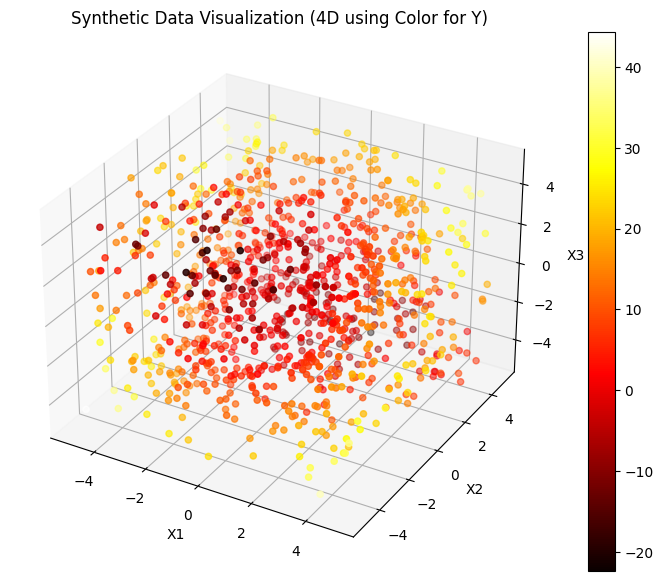

In [14]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y[:, 0], cmap=plt.hot())
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
fig.colorbar(img)
plt.title('Synthetic Data Visualization (4D using Color for Y)')
plt.show()


In [16]:
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [17]:
class NonlinearModel(pl.LightningModule):
    def __init__(self, input_size=3, hidden_size=64, output_size=1):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = torch.einsum('ij,jk->ik', x, self.layer1.weight.T) + self.layer1.bias
        x = self.activation(x)
        x = torch.einsum('ij,jk->ik', x, self.layer2.weight.T) + self.layer2.bias
        x = self.activation(x)
        x = torch.einsum('ij,jk->ik', x, self.layer3.weight.T) + self.layer3.bias
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return test_loader


In [18]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64)


In [19]:
model = NonlinearModel()
trainer = pl.Trainer(
    callbacks=[EarlyStopping(monitor='train_loss', patience=10)],
    max_epochs=100,
    accelerator='cpu'
)

trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type   | Params
--------------------------------------
0 | layer1     | Linear | 256   
1 | layer2     | Linear | 4.2 K 
2 | layer3     | Linear | 65    
3 | activation | ReLU   | 0     
--------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

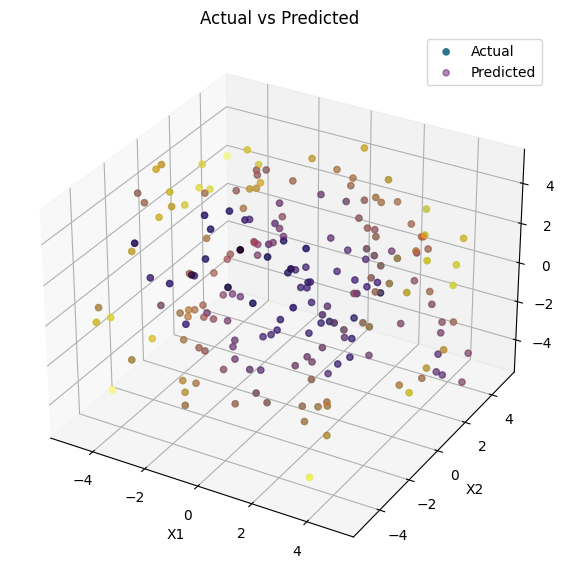

In [20]:
model.eval()  # Set the model to evaluation mode
y_pred = model(torch.tensor(X_test, dtype=torch.float32)).detach().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test[:, 0], cmap='viridis', label='Actual')
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_pred[:, 0], cmap='inferno', alpha=0.5, label='Predicted')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()
